In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy
import sklearn
from scipy import stats
from joblib import Parallel, delayed

In [2]:
##Wavenumbers
k = 12 * np.pi
m = 6 * np.pi
m_U = 14 * np.pi #vertical wavenumber
##

r_m = 0.1
N0_squared = 100


k_e = np.sqrt(k**2 + m**2)
k_plus = np.sqrt(k**2 +(m+m_U)**2)

W_e = np.array([[-1, k / (k_e**2)],
                [-k * N0_squared, -1]])
W_plus = np.array([[-1, -k / (k_plus**2)],
                [k * N0_squared, -1]])

W = np.block([[W_e, np.zeros((2, 2))],
             [np.zeros((2, 2)), W_plus]])

L_e = np.array([[-(k*(k_plus**2 - m_U**2)) / (2 * (k_e**2)), 0],
                [0, k / 2]])

L_plus = np.array([[-(k*(m_U**2 - k_e**2)) / (2 * (k_plus**2)), 0],
                [0, -k / 2]])

L = np.block([[np.zeros((2, 2)), L_e],
             [L_plus, np.zeros((2, 2))]])

In [3]:
initial_state = np.array([[0, 0, 0, 0, 0.001]]).T  #The initial state for the y_em output where the concatenated array looks like [psi_e, b_e, psi_plus, b_plus, U]
t_span = (0, 1100)
dt = 0.001
epsilon = 0.01  #noise strength (0.01 has been well used)


#The function below uses the Euler Maruyama method which is used to solve Stochastic Differential Equations (SDEs)
def euler_maruyama(y0, t_span, dt, epsilon):
    t0, tf = t_span
    t = np.linspace(t0, tf, int((tf - t0) / dt) + 1)
    s = np.zeros((4, len(t)))
    U = np.zeros(len(t))
    R = np.zeros(len(t))

    s[:, 0] = y0[:4].ravel()
    U[0] = y0[4]
    R[0] = 0

    for i in range(len(t) - 1):
        noise_forcing = np.sqrt(dt) * (2 * np.sqrt(2) / k_e) * np.random.normal(0, 1)
        noise_forcing_vector = np.array([noise_forcing, 0, 0, 0])
        psi_e = s[0, i]
        psi_p = s[2, i]
        s[:, i + 1] = s[:, i] + dt * (W @ s[:, i] + U[i] * (L @ s[:, i])) + np.sqrt(epsilon) * noise_forcing_vector
        U[i + 1] = U[i] + dt * ((0.25 * k * (k_plus**2 - k_e**2) * psi_e * psi_p) - (r_m * U[i]))

    y = np.vstack((s, U))
    return t, y

In [4]:
## The code below is used to generate the training data for the neural network

t_span = (0, 11000) # Time span
dt = 0.001  # Time step

t, y = euler_maruyama(initial_state, t_span, dt, epsilon)   # Solve the SDE
R = 0.25 * k * (k_plus**2 - k_e**2) * y[0] * y[2] 

# Extract the desired values
U = y[4]  # Extract U values

# Find the index corresponding to time t=100
start_index = int(100 / dt) 

# Slice U and R arrays starting from the index of t=100
U = U[start_index:]
R = R[start_index:]

# Create a DataFrame with U and R
df = pd.DataFrame({'U': U, 'R': R})


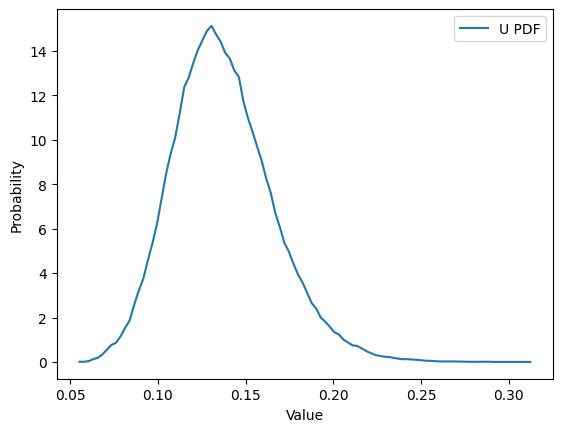

In [10]:
# Calculate the histogram (PDF approximation) for U and R data
num_bins = 100  # You can adjust the number of bins to get better resolution
U_hist, U_bins = np.histogram(U, bins=num_bins, density=True)
R_hist, R_bins = np.histogram(R, bins=num_bins, density=True)

plt.figure()
plt.plot(U_bins[:-1], U_hist, label='U PDF')
# plt.plot(R_bins[:-1], R_hist, label='R PDF')
plt.xlabel('Value')
plt.ylabel('Probability')
plt.legend()
plt.show()

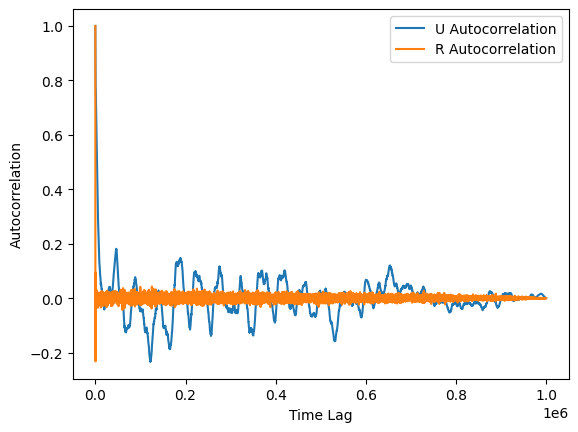

In [23]:
# Plot autocorrelation functions
plt.figure()
plt.plot(U_autocorr, label='U Autocorrelation')
plt.plot(R_autocorr, label='R Autocorrelation')
plt.xlabel('Time Lag')
plt.ylabel('Autocorrelation')
plt.legend()
plt.show()

In [5]:
def autocorrelation_fft(data):
    data = data - np.mean(data)  # Remove the mean
    n = len(data)
    
    # Compute the power spectral density (PSD)
    data_fft = np.fft.fft(data, n=2*n)  # Zero-padding for avoiding circular convolution
    psd = np.abs(data_fft)**2
    
    # Compute the inverse Fourier transform of the PSD
    autocorr = np.fft.ifft(psd)
    
    # Keep only the positive lags and normalize the result
    autocorr = autocorr[:n].real
    autocorr /= autocorr[0]

    return autocorr

# Calculate autocorrelation functions for U and R
U_autocorr = autocorrelation_fft(U)
# R_autocorr = autocorrelation_fft(R)

In [6]:
#Replace df['R'] with Rolling mean of R with window size 1000
df['R'] = df['R'].rolling(1000).mean()

# Add autocorrelation of U to the DataFrame
df['U_autocorr'] = U_autocorr
# # Add new features for U
# #rolling standard deviation of U
# df['std'] = df['U'].rolling(100).std()

# #rolling standard deviation of U (window size 1000)
# df['std2'] = df['U'].rolling(1000).std()

# #rolling variance of U
# df['var'] = df['U'].rolling(100).var()

# #rolling variance of U (window size 1000)
# df['var2'] = df['U'].rolling(1000).var()

# #rolling skewness of U
# df['skew'] = df['U'].rolling(100).skew()

# #rolling skewness of U (window size 1000)
# df['skew2'] = df['U'].rolling(1000).skew()

# #rolling kurtosis of U
# df['kurt'] = df['U'].rolling(100).kurt()

# #rolling kurtosis of U (window size 1000)
# df['kurt2'] = df['U'].rolling(1000).kurt()


# moving average of U (window size 100)
df['mov_avg'] = df['U'].rolling(100).mean()

# moving average of U (window size 1000)
df['mov_avg2'] = df['U'].rolling(1000).mean()

# moving average of U (window size 10000)
df['mov_avg3'] = df['U'].rolling(10000).mean()

# # exponential moving average of U (window size 100)
# df['exp_mov_avg'] = df['U'].ewm(span=100, adjust=False).mean()

# # exponential moving average of U (window size 1000)
# df['exp_mov_avg2'] = df['U'].ewm(span=1000, adjust=False).mean()


# df['detrend1'] = df['U'] - df['U'].rolling(100).mean() #detrended U (detrended by the rolling window of size 100)

# df['detrend2'] = df['U'] - df['U'].rolling(1000).mean()     #detrended U (detrended by the rolling window of size 1000)

# df['detrend3'] = df['U'] - df['U'].rolling(10000).mean()     #detrended U (detrended by the rolling window of size 10000)



df = df.dropna() #drop the rows with NaN values

df.to_csv('./data/train_data_autocorr.csv', index=False) #save the dataframe as a csv file


In [7]:
#From the df dataframe, subsample the rows with a step size of 8500 and save it as a new dataframe and then save it as a csv file
df2 = df.iloc[::8500, :]
df2.to_csv('./data/train_data_subsampled_autocorr.csv', index=False)

In [25]:
#display nan values
print(df.isnull().sum())

U                  0
R                  0
std               99
std2             999
var               99
var2             999
mov_avg           99
mov_avg2         999
mov_avg3        9999
exp_mov_avg        0
exp_mov_avg2       0
detrend1          99
detrend2         999
detrend3        9999
dtype: int64


In [ ]:
t_span = (0, 10000)
dt = 0.001

t, y = euler_maruyama(initial_state, t_span, dt, epsilon)
R = 0.25 * k * (k_plus**2 - k_e**2) * y[0] * y[2]

# Extract the desired values
U = y[4]  # Extract U values

# Ensure both arrays have the same length
min_length = min(len(U), len(R))
U = U[:min_length]
R = R[:min_length]

# Find the index corresponding to time t=100
start_index = int(100 / dt)

# Slice U and R arrays starting from the index of t=100
U_slice = U[start_index:]
R_slice = R[start_index:]

# Make a new U and R so that each data is separated by 8.5 time units
U = U_slice[::int(8.5 / dt)]
R = R_slice[::int(8.5 / dt)]

# Create a DataFrame with y[4] and R
df = pd.DataFrame({'U': U, 'R': R})


# Save the DataFrame to a CSV file
df.to_csv('/home/nurul/Codes_Summer/train_test/test_data_cut.csv', index=False)


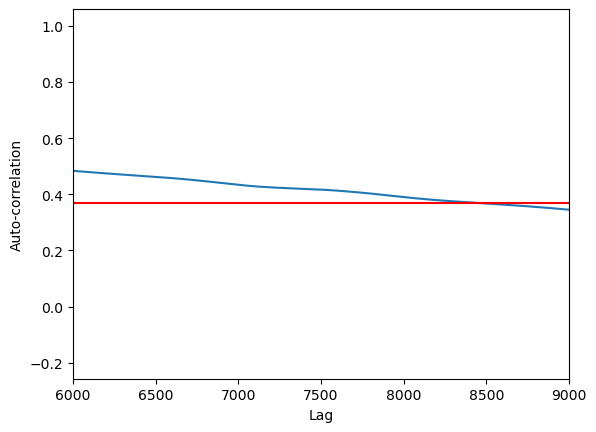

In [8]:
# Calculate the time-averaged U
time_avg_U = np.mean(U)

# Calculate U'
U_prime = U - time_avg_U

# Compute the correlation with FFT
U_prime_fft = np.fft.fft(U_prime)
U_prime_fft = np.abs(U_prime_fft) ** 2
U_prime_fft = np.fft.ifft(U_prime_fft)
U_prime_fft = np.real(U_prime_fft)

# Extract the positive lags
U_prime_fft = U_prime_fft[:len(U_prime_fft) // 2]

# Normalize the auto-correlation function
U_prime_fft = U_prime_fft / U_prime_fft[0]

# Plot the auto-correlation function
plt.plot(U_prime_fft)
plt.xlabel('Lag')
plt.ylabel('Auto-correlation')
#plt.xlim(6000,9000)
plt.axhline(y=1/np.e, color='r', linestyle='-')
plt.show()